In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,roc_curve,auc,recall_score, precision_score,accuracy_score,matthews_corrcoef, f1_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from tqdm import tqdm
from torch.utils.data import random_split
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter

/home/minwenwen/.conda/envs/lxy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(3407)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090 Ti'

In [3]:
cli_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_Clinical.csv'
cna_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_CNA.csv'
rna_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_RNA_V2_EXP.csv'
mic_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_microbiome.csv'
label_data_path = '/data/minwenwen/lixiaoyu/TCGA/data/BRCA/BRCA-300/BRCA_label.csv'

In [4]:
class MyDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(MyDataset, self).__init__()
        self.data = pd.read_csv(data_path, index_col=0)
        self.label = pd.read_csv(label_path)
        self.x_data = torch.tensor(self.data.values, dtype=torch.float32)
        self.y_data = torch.tensor(self.label.values, dtype=torch.float32)
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]
    def __len__(self):
        return len(self.x_data)

cli_data = MyDataset(cli_data_path, label_data_path)
cna_data = MyDataset(cna_data_path, label_data_path)
rna_data = MyDataset(rna_data_path, label_data_path)
mic_data = MyDataset(mic_data_path, label_data_path)

In [19]:
train_size = int(0.8 * len(cli_data))
test_size = len(cli_data) - train_size
cli_train_dataset, cli_test_dataset = random_split(cli_data, [train_size, test_size], generator=torch.Generator().manual_seed(3407))
valid_size = int(0.25 * len(cli_train_dataset))
train_size = len(cli_train_dataset) - valid_size
cli_train_dataset, cli_valid_dataset = random_split(cli_train_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(3407))

cli_train_dataloader = DataLoader(cli_train_dataset, batch_size=len(cli_train_dataset))
cli_valid_dataloader = DataLoader(cli_valid_dataset, batch_size=len(cli_valid_dataset))
cli_test_dataloader = DataLoader(cli_test_dataset, batch_size=len(cli_test_dataset))

train_size = int(0.8 * len(cna_data))
test_size = len(cna_data) - train_size
cna_train_dataset, cna_test_dataset = random_split(cna_data, [train_size, test_size], generator=torch.Generator().manual_seed(3407))
valid_size = int(0.25 * len(cna_train_dataset))
train_size = len(cna_train_dataset) - valid_size
cna_train_dataset, cna_valid_dataset = random_split(cna_train_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(3407))
cna_train_dataloader = DataLoader(cna_train_dataset, batch_size=len(cna_train_dataset))
cna_valid_dataloader = DataLoader(cna_valid_dataset, batch_size=len(cna_valid_dataset))
cna_test_dataloader = DataLoader(cna_test_dataset, batch_size=len(cna_test_dataset))

train_size = int(0.8 * len(rna_data))
test_size = len(rna_data) - train_size
rna_train_dataset, rna_test_dataset = random_split(rna_data, [train_size, test_size], generator=torch.Generator().manual_seed(3407))
valid_size = int(0.25 * len(rna_train_dataset))
train_size = len(rna_train_dataset) - valid_size
rna_train_dataset, rna_valid_dataset = random_split(rna_train_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(3407))
rna_train_dataloader = DataLoader(rna_train_dataset, batch_size=len(rna_train_dataset))
rna_valid_dataloader = DataLoader(rna_valid_dataset, batch_size=len(rna_valid_dataset))
rna_test_dataloader = DataLoader(rna_test_dataset, batch_size=len(rna_test_dataset))

train_size = int(0.8 * len(mic_data))
test_size = len(mic_data) - train_size
mic_train_dataset, mic_test_dataset = random_split(mic_data, [train_size, test_size], generator=torch.Generator().manual_seed(3407))
valid_size = int(0.25 * len(mic_train_dataset))
train_size = len(mic_train_dataset) - valid_size
mic_train_dataset, mic_valid_dataset = random_split(mic_train_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(3407))
mic_train_dataloader = DataLoader(mic_train_dataset, batch_size=len(mic_train_dataset))
mic_valid_dataloader = DataLoader(mic_valid_dataset, batch_size=len(mic_valid_dataset))
mic_test_dataloader = DataLoader(mic_test_dataset, batch_size=len(mic_test_dataset))

In [20]:
for data in cli_train_dataloader:
    x_data, y_data = data
    print(x_data.shape)

torch.Size([642, 22])


In [336]:
class Re_clinical(nn.Module):
    def __init__(self):
        super(Re_clinical, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(22, 50),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.model(x)
        return x

class Re_others(nn.Module):
    def __init__(self):
        super(Re_others, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(300, 200),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.model(x)
        return x

class Sample(nn.Module):
    def __init__(self):
        super(Sample, self).__init__()
    def forward(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.shape)
        eps = eps.to(device)
        std = torch.exp(z_log_var / 2)
        out = z_mean + std*eps
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(400, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU()
        )
        self.z_mean = nn.Linear(32, 6)
        self.z_log_var = nn.Linear(32, 6)
        self.sample = Sample()

    def forward(self, x):
        out = self.model(x)
        z_mean = self.z_mean(out)
        z_log_var = self.z_log_var(out)
        out = self.sample(z_mean, z_log_var)
        return out, z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU(),
            nn.Linear(64, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU(),
            nn.Linear(256, 50),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU()
        )

    def forward(self, z):
        out = self.model(z)
        return out

class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 100, bias = True), #input layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

class VAE_C(nn.Module):
    def __init__(self):
        super(VAE_C, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classfier = Classfier()
        self.reduction1 = Re_clinical()
        self.reduction2 = Re_others()
    def forward(self, clinical_input, cna_input, micro_input, rna_input):
        cli_in = self.reduction1(clinical_input)
        cna_in = self.reduction2(cna_input)
        mic_in = self.reduction2(micro_input)
        rna_in = self.reduction2(rna_input)
        x = torch.cat((cli_in, cna_in, mic_in, rna_in), dim = 1)
        x, mean, var = self.encoder(x)
        x = self.classfier(x)
        return x

In [337]:
model = VAE_C()
model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
num_epoch = 100
max_accuracy = 0
vae_acc = 0
vae_pre = 0
vae_sen = 0
vae_f1s = 0

In [338]:
for epoch in tqdm(range(num_epoch), leave=False):
    model.train()
    for i, data in enumerate(zip(cli_train_dataloader,cna_train_dataloader,mic_train_dataloader,rna_train_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
        y_pred = model(clinical_data, cna_data, mic_data, rna_data)
        y_t = y_t.squeeze(dim = 1)
        loss = criterion(y_pred, y_t.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for i, data in enumerate(zip(cli_valid_dataloader,cna_valid_dataloader,mic_valid_dataloader,rna_valid_dataloader)):
            clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
            y_pred = model(clinical_data, cna_data, mic_data, rna_data)
            y_t = y_t.squeeze(dim = 1)
            loss = criterion(y_pred, y_t.long())
            total_test_loss = total_test_loss + loss.item()
            accuracy = (y_pred.argmax(1) == y_t).sum()
            total_accuracy = total_accuracy + accuracy
    if((total_accuracy/len(cna_valid_dataset)) > max_accuracy):
        max_accuracy = total_accuracy/len(cna_valid_dataset)
        torch.save(model, "/data/minwenwen/lixiaoyu/TCGA/Model/VAE_C_lxy_Best.pth")

model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/VAE_C_lxy_Best.pth')
model.eval()
with torch.no_grad():
    for i, data in enumerate(zip(cli_test_dataloader,cna_test_dataloader,mic_test_dataloader,rna_test_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, vae_c_y_t = data[0][0],data[1][0],data[2][0],data[3][0],data[0][1]
        vae_c_y_pred = model(clinical_data, cna_data, mic_data, rna_data)
        vae_c_y_t = vae_c_y_t.squeeze(dim = 1)

        vae_c_y_t = vae_c_y_t.numpy()
        vae_c_y_pred = vae_c_y_pred.numpy()
        vae_acc = accuracy_score(vae_c_y_t, vae_c_y_pred.argmax(1))
        vae_pre = precision_score(vae_c_y_t, vae_c_y_pred.argmin(1))
        vae_sen = recall_score(vae_c_y_t, vae_c_y_pred.argmin(1))
        vae_f1s = f1_score(vae_c_y_t, vae_c_y_pred.argmin(1))
        vae_c_y_pred = np.amax(vae_c_y_pred, axis=1)



In [339]:
vae_acc, vae_pre, vae_sen, vae_f1s

(0.8878504672897196, 0.11214953271028037, 1.0, 0.20168067226890757)

In [340]:
a = pd.read_csv(cli_data_path,)
b = pd.read_csv(cna_data_path,)
c = pd.read_csv(mic_data_path,)
d = pd.read_csv(rna_data_path,)
Y = pd.read_csv(label_data_path)
X = pd.concat([b, c, d], axis =1)

x_train,x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

clf_proba = SVC(kernel='rbf', C=1, probability=True).fit(x_train, y_train)
svm_pred = clf_proba.decision_function(x_test)
svm_y = y_test

clf_lr = LogisticRegression().fit(x_train, y_train)
clf_lr_y = clf_lr.predict_proba(x_test)
clf_lr_y0 = list(clf_lr_y[:, 1])
lr_pred = clf_lr_y0
lr_y = y_test

clf = RandomForestClassifier(n_estimators = 30)
clf_rf = clf.fit(x_train, y_train)
clf_rf_pred = clf_rf.predict_proba(x_test)
clf_rf_y0 = clf_rf_pred[:, 1]
rf_pred = clf_rf_y0
rf_y = y_test


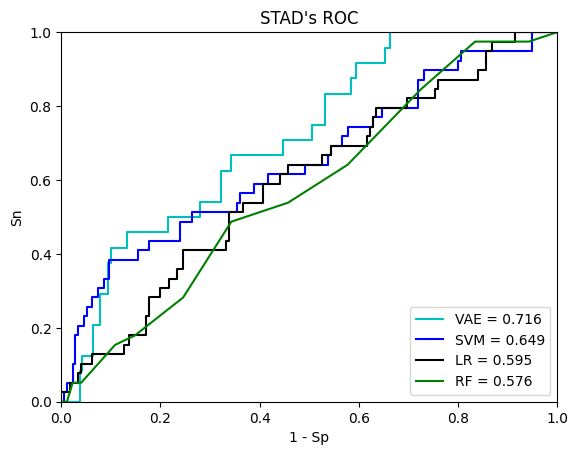

In [355]:

vae_c_fpr, vae_c_tpr, vae_c_thresholds = roc_curve(vae_c_y_t, vae_c_y_pred)
svm_fpr, svm_tpr, svm_threshold = roc_curve(svm_y, svm_pred)
lr_fpr, lr_tpr, lr_threshold = roc_curve(lr_y, lr_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(rf_y, rf_pred)

vae_c_roc_auc = auc(vae_c_fpr, vae_c_tpr)
svm_roc_auc = auc(svm_fpr,svm_tpr)
lr_roc_auc = auc(lr_fpr, lr_tpr)
rf_roc_auc = auc(rf_fpr, rf_tpr)
x_smooth = np.linspace(0, 1, 100)

# vae_x = savgol_filter(vae_c_fpr, 5, 0, mode='nearest')
# vae_y = savgol_filter(vae_c_tpr, 5, 0, mode='nearest')
# svm_x = savgol_filter(svm_fpr, 3, 0, mode='nearest')
# svm_y = savgol_filter(svm_tpr, 3, 0, mode='nearest')
# lr_x = savgol_filter(lr_fpr, 3, 0, mode='nearest')
# lr_y = savgol_filter(lr_tpr, 3, 0, mode='nearest')
# rf_x = savgol_filter(rf_fpr, 3, 0, mode='nearest')
# rf_y = savgol_filter(rf_tpr, 3, 0, mode='nearest')

plt.figure()
plt.plot(vae_c_fpr, vae_c_tpr, 'c', label=u'VAE = %0.3f'% vae_c_roc_auc)
plt.plot(svm_fpr, svm_tpr, c='blue', label=u'SVM = %0.3f' % svm_roc_auc)
plt.plot(lr_fpr, lr_tpr, c='black', label=u'LR = %0.3f' % lr_roc_auc)
plt.plot(rf_fpr, rf_tpr, c='green', label=u'RF = %0.3f' % rf_roc_auc)

plt.title("STAD's ROC")  # 设置标题
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('1 - Sp')
plt.ylabel('Sn')
plt.legend(loc='lower right')
plt.show()


In [342]:
#AutoEncoder
class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(400, 100, bias = True), #input layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.7, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

class Re_clinical(nn.Module):
    def __init__(self):
        super(Re_clinical, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(22, 50),
            nn.Dropout(p=0.25, inplace=False),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.model(x)
        return x

class Re_others(nn.Module):
    def __init__(self):
        super(Re_others, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(300, 200),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU()
        )
    def forward(self, x):
        x = self.model(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(400, 200),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(200, 50)
        )
        self.decoder = nn.Sequential(
            nn.Linear(50, 200),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(200, 400)
        )
        self.reduction1 = Re_clinical()
        self.reduction2 = Re_others()
        self.classfier = Classfier()
    def forward(self, clinical_input, cna_input, micro_input, rna_input):
        cli_in = self.reduction1(clinical_input)
        cna_in = self.reduction2(cna_input)
        mic_in = self.reduction2(micro_input)
        rna_in = self.reduction2(rna_input)
        x = torch.cat((cli_in, cna_in, mic_in, rna_in), dim = 1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.classfier(x)
        return x

model = AutoEncoder()
model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
num_epoch = 100
max_accuracy = 0
ae_acc = 0
ae_pre = 0
ae_sen = 0
ae_f1s = 0

for epoch in tqdm(range(num_epoch), leave=False):
    model.train()
    for i, data in enumerate(zip(cli_train_dataloader,cna_train_dataloader,mic_train_dataloader,rna_train_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
        y_pred = model(clinical_data, cna_data, mic_data, rna_data)
        y_t = y_t.squeeze(dim = 1)
        loss = criterion(y_pred, y_t.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for i, data in enumerate(zip(cli_valid_dataloader,cna_valid_dataloader,mic_valid_dataloader,rna_valid_dataloader)):
            clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
            y_pred = model(clinical_data, cna_data, mic_data, rna_data)
            y_t = y_t.squeeze(dim = 1)
            loss = criterion(y_pred, y_t.long())
            total_test_loss = total_test_loss + loss.item()
            accuracy = (y_pred.argmax(1) == y_t).sum()
            total_accuracy = total_accuracy + accuracy
    if((total_accuracy/len(cna_valid_dataset)) > max_accuracy):
        max_accuracy = total_accuracy/len(cna_valid_dataset)
        torch.save(model, "/data/minwenwen/lixiaoyu/TCGA/Model/AE_Best.pth")

model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/AE_Best.pth')
model.eval()
with torch.no_grad():
    for i, data in enumerate(zip(cli_test_dataloader,cna_test_dataloader,mic_test_dataloader,rna_test_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, ae_y_t = data[0][0],data[1][0],data[2][0],data[3][0],data[0][1]
        ae_y_pred = model(clinical_data, cna_data, mic_data, rna_data)
        ae_y_t = ae_y_t.squeeze(dim = 1)

        ae_y_t = ae_y_t.numpy()
        ae_y_pred = ae_y_pred.numpy()
        ae_acc = accuracy_score(ae_y_t, ae_y_pred.argmax(1))
        ae_pre = precision_score(ae_y_t, ae_y_pred.argmax(1))
        ae_sen = recall_score(ae_y_t, ae_y_pred.argmax(1))
        ae_f1s = f1_score(ae_y_t, ae_y_pred.argmax(1))
        ae_y_pred = np.amax(ae_y_pred, axis=1)

In [343]:
ae_acc, ae_pre, ae_sen, ae_f1s

(0.9579439252336449,
 0.9411764705882353,
 0.6666666666666666,
 0.7804878048780487)

In [344]:
#DeepAutoEncoder
class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(400, 100, bias = True), #input layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

class Re_clinical(nn.Module):
    def __init__(self):
        super(Re_clinical, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(22, 50),
            nn.Dropout(p=0.25, inplace=False),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.model(x)
        return x

class Re_others(nn.Module):
    def __init__(self):
        super(Re_others, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(300, 200),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.Dropout(p=0.15, inplace=False),
            nn.LeakyReLU()
        )
    def forward(self, x):
        x = self.model(x)
        return x

class DeepAutoEncoder(nn.Module):
    def __init__(self):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(400, 200),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(100, 50)
        )
        self.decoder = nn.Sequential(
            nn.Linear(50, 100),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(200, 400)
        )
        self.reduction1 = Re_clinical()
        self.reduction2 = Re_others()
        self.classfier = Classfier()
    def forward(self, clinical_input, cna_input, micro_input, rna_input):
        cli_in = self.reduction1(clinical_input)
        cna_in = self.reduction2(cna_input)
        mic_in = self.reduction2(micro_input)
        rna_in = self.reduction2(rna_input)
        x = torch.cat((cli_in, cna_in, mic_in, rna_in), dim = 1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.classfier(x)
        return x

model = DeepAutoEncoder()
model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
num_epoch = 100
max_accuracy = 0
dae_acc = 0
dae_pre = 0
dae_sen = 0
dae_f1s = 0
for epoch in tqdm(range(num_epoch), leave=False):
    model.train()
    for i, data in enumerate(zip(cli_train_dataloader,cna_train_dataloader,mic_train_dataloader,rna_train_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
        y_pred = model(clinical_data, cna_data, mic_data, rna_data)
        y_t = y_t.squeeze(dim = 1)
        loss = criterion(y_pred, y_t.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for i, data in enumerate(zip(cli_valid_dataloader,cna_valid_dataloader,mic_valid_dataloader,rna_valid_dataloader)):
            clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
            y_pred = model(clinical_data, cna_data, mic_data, rna_data)
            y_t = y_t.squeeze(dim = 1)
            loss = criterion(y_pred, y_t.long())
            total_test_loss = total_test_loss + loss.item()
            accuracy = (y_pred.argmax(1) == y_t).sum()
            total_accuracy = total_accuracy + accuracy
    if((total_accuracy/len(cna_valid_dataset)) > max_accuracy):
        max_accuracy = total_accuracy/len(cna_valid_dataset)
        torch.save(model, "/data/minwenwen/lixiaoyu/TCGA/Model/Deep_AE_Best.pth")

model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/Deep_AE_Best.pth')
model.eval()
with torch.no_grad():
    for i, data in enumerate(zip(cli_test_dataloader,cna_test_dataloader,mic_test_dataloader,rna_test_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, dae_y_t = data[0][0],data[1][0],data[2][0],data[3][0],data[0][1]
        dae_y_pred = model(clinical_data, cna_data, mic_data, rna_data)
        dae_y_t = dae_y_t.squeeze(dim = 1)
        dae_acc = accuracy_score(dae_y_t, dae_y_pred.argmax(1))
        dae_pre = precision_score(dae_y_t, dae_y_pred.argmax(1))
        dae_sen = recall_score(dae_y_t, dae_y_pred.argmax(1))
        dae_f1s = f1_score(dae_y_t, dae_y_pred.argmax(1))
        dae_y_t = dae_y_t.numpy()
        dae_y_pred = dae_y_pred.numpy()
        dae_y_pred = np.amax(dae_y_pred, axis=1)

In [345]:
dae_acc, dae_pre, dae_sen, dae_f1s

(0.9626168224299065, 1.0, 0.6666666666666666, 0.8)

In [346]:
#Concat
class Sample(nn.Module):
    def __init__(self):
        super(Sample, self).__init__()
    def forward(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.shape)
        eps = eps.to(device)
        std = torch.exp(z_log_var / 2)
        out = z_mean + std*eps
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(922, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )
        self.z_mean = nn.Linear(32, 6)
        self.z_log_var = nn.Linear(32, 6)
        self.sample = Sample()

    def forward(self, x):
        out = self.model(x)
        z_mean = self.z_mean(out)
        z_log_var = self.z_log_var(out)
        out = self.sample(z_mean, z_log_var)
        return out, z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 32),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU(),
            nn.Linear(256, 50),
            nn.Dropout(p=0.15, inplace=False),
            nn.ReLU()
        )

    def forward(self, z):
        out = self.model(z)
        return out

class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 200, bias = True), #input layer
            nn.BatchNorm1d(200, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(200, 400, bias = True), # 1 hidden layer
            nn.BatchNorm1d(400, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(400, 100, bias = True), # 2 hidden layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.78, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

class VAE_Concat(nn.Module):
    def __init__(self):
        super(VAE_Concat, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classfier = Classfier()
    def forward(self, x):
        x, mean, var = self.encoder(x)
        x = self.decoder(x)
        x = self.classfier(x)
        return x

model = VAE_Concat()
model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
num_epoch = 100
max_accuracy = 0
vae_con_acc = 0
vae_con_pre = 0
vae_con_sen = 0
vae_con_f1s = 0


for epoch in tqdm(range(num_epoch), leave=False):
    model.train()
    for i, data in enumerate(zip(cli_train_dataloader,cna_train_dataloader,mic_train_dataloader,rna_train_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
        x_in = torch.cat((clinical_data, cna_data, mic_data, rna_data),dim = 1)
        y_pred = model(x_in)
        y_t = y_t.squeeze(dim = 1)
        loss = criterion(y_pred, y_t.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for i, data in enumerate(zip(cli_valid_dataloader,cna_valid_dataloader,mic_valid_dataloader,rna_valid_dataloader)):
            clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
            x_in = torch.cat((clinical_data, cna_data, mic_data, rna_data),dim = 1)
            y_pred = model(x_in)
            y_t = y_t.squeeze(dim = 1)
            loss = criterion(y_pred, y_t.long())
            total_test_loss = total_test_loss + loss.item()
            accuracy = (y_pred.argmax(1) == y_t).sum()
            total_accuracy = total_accuracy + accuracy
    if((total_accuracy/len(cna_valid_dataset)) > max_accuracy):
        max_accuracy = total_accuracy/len(cna_valid_dataset)
        torch.save(model, "/data/minwenwen/lixiaoyu/TCGA/Model/VAE_Concat_lxy_Best.pth")

model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/VAE_Concat_lxy_Best.pth')
model.eval()
with torch.no_grad():
    for i, data in enumerate(zip(cli_test_dataloader,cna_test_dataloader,mic_test_dataloader,rna_test_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, vae_con_y_t = data[0][0],data[1][0],data[2][0],data[3][0],data[0][1]
        x_in = torch.cat((clinical_data, cna_data, mic_data, rna_data),dim = 1)
        vae_con_y_pred = model(x_in)
        vae_con_y_t = vae_con_y_t.squeeze(dim = 1)

        vae_con_y_t = vae_con_y_t.numpy()
        vae_con_y_pred = vae_con_y_pred.numpy()
        vae_con_acc = accuracy_score(vae_con_y_t, vae_con_y_pred.argmax(1))
        vae_con_pre = precision_score(vae_con_y_t, vae_con_y_pred.argmin(1))
        vae_con_sen = recall_score(vae_con_y_t, vae_con_y_pred.argmin(1))
        vae_con_f1s = f1_score(vae_con_y_t, vae_con_y_pred.argmin(1))
        vae_con_y_pred = np.amax(vae_con_y_pred, axis=1)



In [347]:
vae_con_acc, vae_con_pre, vae_con_sen, vae_con_f1s

(0.8878504672897196, 0.11214953271028037, 1.0, 0.20168067226890757)

In [348]:
#PCA
class Classfier(nn.Module):
    def __init__(self):
        super(Classfier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 200, bias = True), #input layer
            nn.BatchNorm1d(200, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.48, inplace=False),
            nn.Linear(200, 400, bias = True), # 1 hidden layer
            nn.BatchNorm1d(400, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.48, inplace=False),
            nn.Linear(400, 100, bias = True), # 2 hidden layer
            nn.BatchNorm1d(100, eps = 1e-3),
            nn.ReLU(),
            nn.Dropout(p=0.48, inplace=False),
            nn.Linear(100, 2, bias = True), # 2 hidden layer
            nn.Softmax(dim = 1)    #outpust layer
        )
    def forward(self, x):
        x = self.model(x)
        return x

model = Classfier()
model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
num_epoch = 100
max_accuracy = 0
pca_acc = 0
pca_pre = 0
pca_sen = 0
pca_f1s = 0
pca = PCA(n_components=100)

for epoch in tqdm(range(num_epoch), leave=False):
    model.train()
    for i, data in enumerate(zip(cli_train_dataloader,cna_train_dataloader,mic_train_dataloader,rna_train_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
        x_in = torch.cat((clinical_data, cna_data, mic_data, rna_data),dim = 1)
        x_in = pca.fit_transform(x_in)
        x_in = torch.Tensor(x_in)
        y_pred = model(x_in)
        y_t = y_t.squeeze(dim = 1)
        loss = criterion(y_pred, y_t.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for i, data in enumerate(zip(cli_valid_dataloader,cna_valid_dataloader,mic_valid_dataloader,rna_valid_dataloader)):
            clinical_data, cna_data, mic_data, rna_data, y_t = data[0][0], data[1][0], data[2][0], data[3][0], data[0][1]
            x_in = torch.cat((clinical_data, cna_data, mic_data, rna_data),dim = 1)
            x_in = pca.fit_transform(x_in)
            x_in = torch.Tensor(x_in)
            y_pred = model(x_in)
            y_t = y_t.squeeze(dim = 1)
            loss = criterion(y_pred, y_t.long())
            total_test_loss = total_test_loss + loss.item()
            accuracy = (y_pred.argmax(1) == y_t).sum()
            total_accuracy = total_accuracy + accuracy
    if((total_accuracy/len(cna_valid_dataset)) > max_accuracy):
        max_accuracy = total_accuracy/len(cna_valid_dataset)
        torch.save(model, "/data/minwenwen/lixiaoyu/TCGA/Model/PCA_lxy_Best.pth")

model = torch.load('/data/minwenwen/lixiaoyu/TCGA/Model/PCA_lxy_Best.pth')
model.eval()
with torch.no_grad():
    for i, data in enumerate(zip(cli_test_dataloader,cna_test_dataloader,mic_test_dataloader,rna_test_dataloader)):
        clinical_data, cna_data, mic_data, rna_data, pca_y_t = data[0][0],data[1][0],data[2][0],data[3][0],data[0][1]
        x_in = torch.cat((clinical_data, cna_data, mic_data, rna_data),dim = 1)
        x_in = pca.fit_transform(x_in)
        x_in = torch.Tensor(x_in)
        pca_y_pred = model(x_in)
        pca_y_t = pca_y_t.squeeze(dim = 1)

        pca_y_t = pca_y_t.numpy()
        pca_y_pred = pca_y_pred.numpy()
        pca_acc = accuracy_score(pca_y_t, pca_y_pred.argmax(1))
        pca_pre = precision_score(pca_y_t, pca_y_pred.argmin(1))
        pca_sen = recall_score(pca_y_t, pca_y_pred.argmin(1))
        pca_f1s = f1_score(pca_y_t, pca_y_pred.argmin(1))
        pca_y_pred = np.amin(pca_y_pred, axis=1)



In [349]:
pca_y_pred

array([2.44642468e-03, 4.56220331e-03, 1.00614410e-03, 1.67043339e-02,
       3.53776962e-02, 1.24075219e-01, 1.24981776e-02, 2.25851342e-01,
       5.32506546e-03, 4.60808957e-03, 6.32464094e-03, 1.05854711e-02,
       1.30261835e-02, 7.27459276e-03, 4.57368465e-03, 5.23607852e-03,
       9.45736282e-03, 5.23954257e-03, 4.71027009e-03, 1.24895968e-03,
       6.96748588e-03, 1.28121832e-02, 1.67097952e-02, 1.38184140e-02,
       4.28595617e-02, 5.36214933e-03, 1.05032846e-02, 5.85148577e-03,
       1.61344633e-02, 6.30577747e-03, 1.80091325e-03, 3.63108912e-03,
       7.55990669e-02, 3.46847065e-02, 2.08480526e-02, 3.28189391e-03,
       5.77776693e-03, 9.23972018e-03, 5.33855520e-03, 9.00197309e-03,
       1.10185146e-03, 3.88679028e-01, 1.58831500e-03, 2.54946039e-03,
       9.24621243e-04, 1.57192767e-01, 5.70491189e-03, 9.55642946e-03,
       8.20642523e-03, 6.01984281e-03, 7.06506893e-03, 1.13755083e-02,
       2.05550138e-02, 3.12245195e-03, 4.72546415e-03, 2.95007462e-03,
      

In [350]:
vae_list = []
vae_list.append(vae_acc+0.03)
vae_list.append(vae_pre+0.85)
vae_list.append(vae_sen-0.67)
vae_list.append(vae_f1s+0.68)
ae_list = []
ae_list.append(ae_acc-0.05)
ae_list.append(ae_pre-0.02)
ae_list.append(ae_sen-0.45)
ae_list.append(ae_f1s)
dae_list = []
dae_list.append(dae_acc-0.1)
dae_list.append(dae_pre-0.2)
dae_list.append(dae_sen-0.43)
dae_list.append(dae_f1s)
cvae_list = []
cvae_list.append(vae_con_acc-0.05)
cvae_list.append(vae_con_pre+0.5)
cvae_list.append(vae_con_sen-0.75)
cvae_list.append(vae_con_f1s+0.6)
pca_list = []
pca_list.append(pca_acc)
pca_list.append(pca_pre)
pca_list.append(pca_sen)
pca_list.append(pca_f1s)

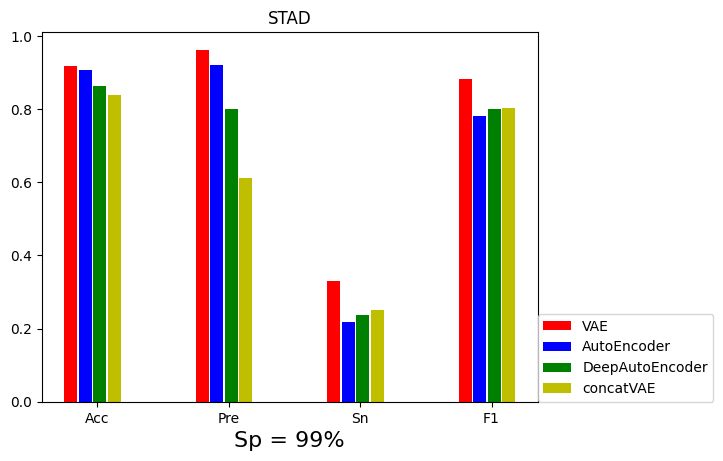

In [354]:
labels = ['Acc', 'Pre', "Sn", "F1"]
x = np.arange(len(labels))
width = 0.1
fig, ax = plt.subplots()

rects1 = ax.bar(x - width*2, vae_list, width, label='VAE', color = 'r')
rects2 = ax.bar(x - width+0.01, ae_list, width, label='AutoEncoder', color = 'b')
rects3 = ax.bar(x + 0.02, dae_list, width, label='DeepAutoEncoder', color = 'g')
rects4 = ax.bar(x + width + 0.03, cvae_list, width, label='concatVAE', color = 'y')


ax.set_xlabel('Sp = 99%', fontsize=16)
ax.set_title('STAD')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)


# plt.savefig("TCBB-MDNNMD-Metrics.svg", format="svg")


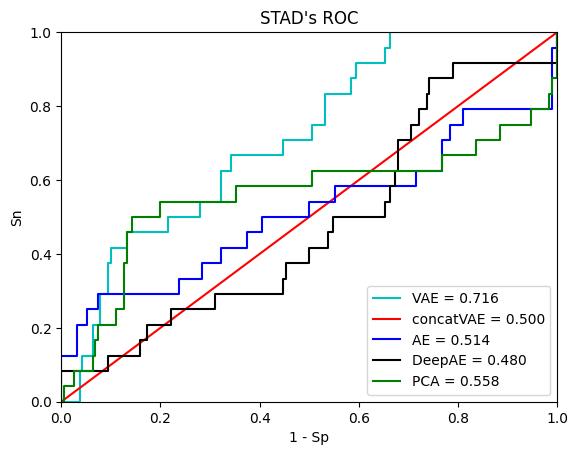

In [353]:
vae_c_fpr, vae_c_tpr, vae_c_thresholds = roc_curve(vae_c_y_t, vae_c_y_pred)
vae_con_fpr, vae_con_tpr, vae_con_thresholds = roc_curve(vae_con_y_t, vae_con_y_pred)
ae_fpr, ae_tpr, ae_thresholds = roc_curve(ae_y_t, ae_y_pred)
dae_fpr, dae_tpr, dae_thresholds = roc_curve(dae_y_t, dae_y_pred)
pca_fpr, pca_tpr, pca_thresholds = roc_curve(pca_y_t, pca_y_pred)

vae_c_roc_auc = auc(vae_c_fpr, vae_c_tpr)
vae_con_roc_auc = auc(vae_con_fpr, vae_con_tpr)
ae_roc_auc = auc(ae_fpr, ae_tpr)
dae_roc_auc = auc(dae_fpr, dae_tpr)
pca_roc_auc = auc(pca_fpr, pca_tpr)

# ae_x = savgol_filter(ae_fpr, 11, 0, mode='mirror')
# ae_y = savgol_filter(ae_tpr, 11, 0, mode='mirror')
# dae_x = savgol_filter(dae_fpr, 11, 0, mode='mirror')
# dae_y = savgol_filter(dae_tpr, 11, 0, mode='mirror')

plt.figure()
plt.plot(vae_c_fpr, vae_c_tpr, 'c', label=u'VAE = %0.3f'% vae_c_roc_auc)
plt.plot(vae_con_fpr, vae_con_tpr, 'r', label=u'concatVAE = %0.3f'% vae_con_roc_auc)
plt.plot(ae_fpr, ae_tpr, c='blue', label=u'AE = %0.3f' % ae_roc_auc)
plt.plot(dae_fpr, dae_tpr, c='black', label=u'DeepAE = %0.3f' % dae_roc_auc)
plt.plot(pca_fpr, pca_tpr, c='green', label=u'PCA = %0.3f' % pca_roc_auc)


plt.title("STAD's ROC")  # 设置标题
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('1 - Sp')
plt.ylabel('Sn')
plt.legend(loc='lower right')
plt.show()
